In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
from sklearn.cluster import AgglomerativeClustering
nltk.download('vader_lexicon')
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.cluster import KMeans
from operator import itemgetter
import random
from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import RegexpTokenizer
from gensim.models import TfidfModel

def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step):
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean, stop, start, step)
    # Show graph
    #print(coherence_values)
    #x = range(start, stop, step)
    #plt.plot(x, coherence_values)
    #plt.xlabel("Number of Topics")
    #plt.ylabel("Coherence score")
    #plt.legend(("coherence_values"), loc='best')
    #plt.show()
    c = coherence_values.index(max(coherence_values))
    return start + c

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/menis/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
data = pd.read_json("10campaignNew.json")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()
text = data["text"].tolist()
scores = list()
positive = list()
negative = list()
neut = list()
for t in text:
    scores.append(vader.polarity_scores(t)['compound'])
    positive.append(vader.polarity_scores(t)['pos'])
    negative.append(vader.polarity_scores(t)['neg'])
    neut.append(vader.polarity_scores(t)['neu'])
print(scores[0])
print(positive[0])
print(negative[0])
print(neut[0])


0.7494
0.285
0.0
0.715


In [3]:
#&amp; is the html special character for &!!!!!! rimuovi!
#data.reset_index(drop=True,inplace=True)
#data.iloc[1332]["text"]

In [4]:
data["vaderScore"] = scores
data.drop(["in_reply_to_user_id_str","is_retweet","text","modded_text","modded1","year","date"],axis=1,inplace=True)
data.corr()

,favorite_count,retweet_count,month,hour,week_year,labels,vaderScore
favorite_count,1.000000,0.929920,0.250773,0.060894,0.239500,-0.070106,-0.063807
retweet_count,0.929920,1.000000,0.242095,0.066795,0.231188,-0.066055,-0.087421
month,0.250773,0.242095,1.000000,0.071850,0.976724,0.018262,-0.043811
hour,0.060894,0.066795,0.071850,1.000000,0.072169,0.021348,-0.042753
week_year,0.239500,0.231188,0.976724,0.072169,1.000000,0.018629,-0.043288
labels,-0.070106,-0.066055,0.018262,0.021348,0.018629,1.000000,0.119918
vaderScore,-0.063807,-0.087421,-0.043811,-0.042753,-0.043288,0.119918,1.000000


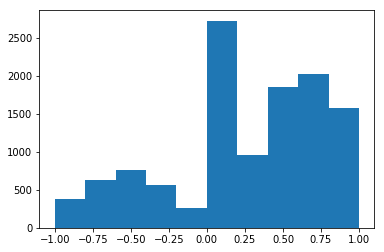

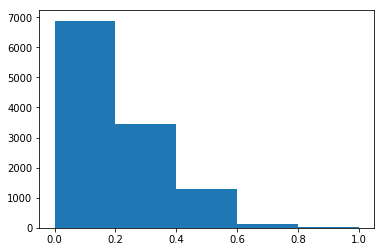

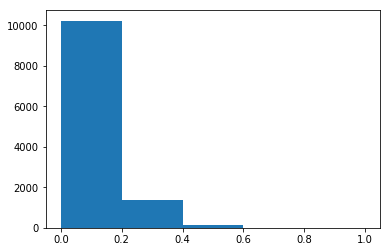

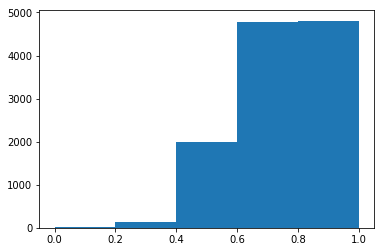

In [5]:
plt.hist(scores,bins=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
plt.show()

plt.hist(positive,bins=[0,0.2,0.4,0.6,0.8,1])
plt.show()

plt.hist(negative,bins=[0,0.2,0.4,0.6,0.8,1])
plt.show()

plt.hist(neut,bins=[0,0.2,0.4,0.6,0.8,1])
plt.show()

0.23019075730471084


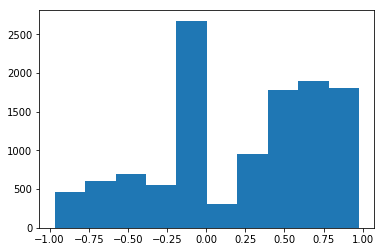

In [6]:
plt.hist(data["vaderScore"])
print(data["vaderScore"].mean())

In [7]:
x1 = data[data["labels"] == 5]
print(len(x1))
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# create a dataframe from a word matrix
def wm2df(wm, feat_names):
    
    # create an index for each row
    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(),
                      columns=feat_names)
    return(df)
  

stemmed_words = pd.Series(' '.join(data['modded1_stemmed']).split()).value_counts()
stemmed_words = stemmed_words[stemmed_words < 2000]
stemmed_words = stemmed_words[stemmed_words > 3]
x1['m'] = data['modded1_stemmed'].apply(lambda x: " ".join(x for x in x.split() if x in stemmed_words))

corpus = x1["m"].tolist()

# instantiate the vectorizer object
cvec = TfidfVectorizer()

# convert the documents into a document-term matrix
wm = cvec.fit_transform(corpus)

# retrieve the terms found in the corpora
tokens = cvec.get_feature_names()

# create a dataframe from the matrix
c = wm2df(wm, tokens)

2183


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(array([2.876e+03, 6.900e+01, 2.000e+01, 9.000e+00, 6.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([   4. ,  168.8,  333.6,  498.4,  663.2,  828. ,  992.8, 1157.6,
        1322.4, 1487.2, 1652. ]),
 <a list of 10 Patch objects>)

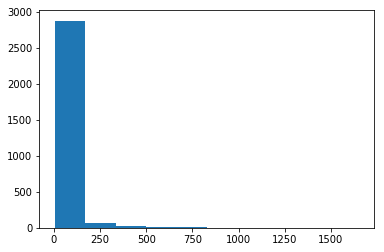

In [8]:
plt.hist(stemmed_words)

In [9]:
x1.reset_index(inplace=True,drop=True)
res = pd.concat([x1,c], axis=1)
#hour peggiora di brutto e monht alza di tanto sse!!!
res1 = res.drop(["month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count","m"],axis=1)
dataWithText = res.drop(["month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1) 
res

,favorite_count,retweet_count,month,hour,week_year,noTags_punct,modded1_stemmed,labels,vaderScore,m,...,yet,york,young,your,youv,yr,zero,zogbi,zone,zuckerman
0,56,24,1,7,1,archangeljf12 realdonaldtrump for president of...,archangeljf12 realdonaldtrump presid unit ...,5,0.4753,presid unit state sentedcruz vice presid,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,24,6,1,21,1,kdanielsk misstcassidy i definitely think ke...,kdanielsk misstcassidi definit think keny...,5,-0.2323,kdanielsk misstcassidi definit think kenya sma...,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,19,2,1,21,1,kdanielsk misstcassidy realdonaldtrump this ...,kdanielsk misstcassidi realdonaldtrump sea...,5,0.6892,kdanielsk misstcassidi season go great cant wait,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,18,8,1,21,1,_snurk realdonaldtrump is so awesome man of na...,_snurk realdonaldtrump awesom man natl u...,5,0.8892,_snurk awesom man natl need leader rule elect ...,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,18,8,1,21,1,morrisfrance excited for the miss universe hi ...,morrisfr excit miss univers hi realdonal...,5,0.2714,excit miss univers hi,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5,23,6,1,21,1,diannelea1958 mfonnest realdonaldtrump apprent...,diannelea1958 mfonnest realdonaldtrump app...,5,-0.4926,apprenticenbc hell ye gonna fun,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
6,28,14,1,3,1,lmechx realdonaldtrump the art of the deal is ...,lmechx realdonaldtrump art deal great re...,5,0.9081,art deal great read fill excel real advic defi...,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
7,57,20,1,20,1,my nbcdfw int by wivankatrump discussing the...,nbcdfw int wivankatrump discuss sunday n...,5,0.0000,int discuss sunday nbc premier apprenticenbc 1...,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
8,26,12,1,23,1,via by soapbox1 showjumping grand prix retu...,via soapbox1 showjump grand prix return ...,5,0.4588,via grand return maralago sunday,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9,33,16,1,3,1,berniesandner realdonaldtrump apprenticenbc im...,berniesandn realdonaldtrump apprenticenbc ...,5,0.3612,apprenticenbc im readi show tomorrow night,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
res1.columns

Index(['week_year', 'vaderScore', '10', '100', '1000', '1000000', '1030',
       '10am', '10pm', '10pme',
       ...
       'yet', 'york', 'young', 'your', 'youv', 'yr', 'zero', 'zogbi', 'zone',
       'zuckerman'],
      dtype='object', length=2482)

# Hierarchical

In [11]:
from sklearn.cluster import AgglomerativeClustering
sil = []
for c in range(40,85):
    clustering = AgglomerativeClustering(affinity='cosine', linkage='complete', n_clusters=c)
    clustering.fit(res1)
    labels = clustering.labels_
    d = silhouette_score(res1, labels,metric='cosine')
    sil.append(d)
    print(c,d)

40 0.5673695527095256


KeyboardInterrupt: 

In [12]:
res1.columns

Index(['week_year', 'vaderScore', '10', '100', '1000', '1000000', '1030',
       '10am', '10pm', '10pme',
       ...
       'yet', 'york', 'young', 'your', 'youv', 'yr', 'zero', 'zogbi', 'zone',
       'zuckerman'],
      dtype='object', length=2482)

In [85]:
res1 = res.drop(["month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count","m"],axis=1)
dataWithText = res.drop(["month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1) 

clustering = AgglomerativeClustering(affinity='cosine', linkage='complete', n_clusters=80) #50 sembra nice, 70 meh 
clustering.fit(res1)
labels = clustering.labels_

In [86]:
d = silhouette_score(res1, labels,metric='cosine')
print(d)

0.5612248592283985


In [87]:
res1["labels"] = labels
dataWithText["labels"] = labels

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cluster  32  lunghezza  2
NUMBER OF TOPICS FOR CLUSTER  32  :  1


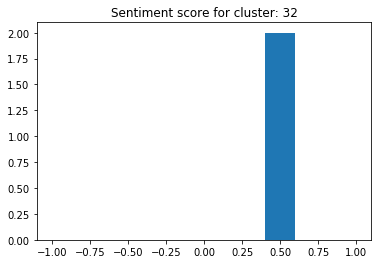

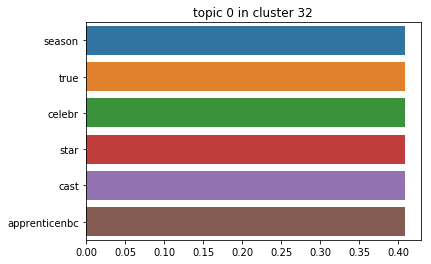

cluster  38  lunghezza  2
NUMBER OF TOPICS FOR CLUSTER  38  :  1


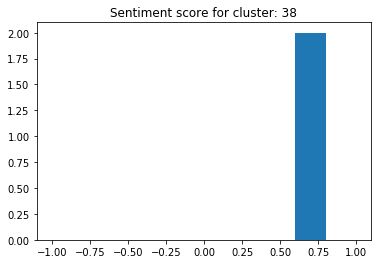

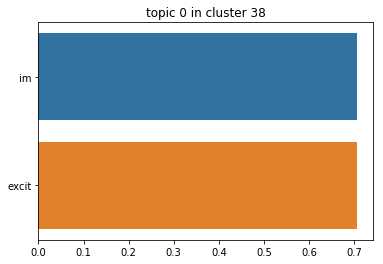

cluster  10  lunghezza  3
NUMBER OF TOPICS FOR CLUSTER  10  :  8


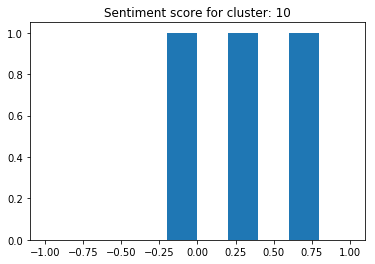

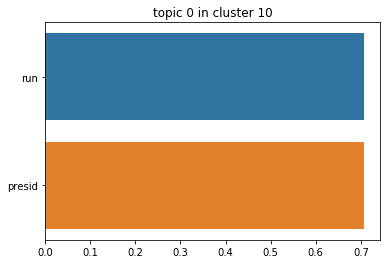

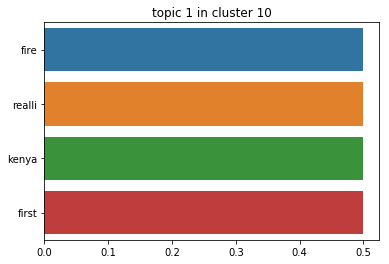

cluster  24  lunghezza  3
NUMBER OF TOPICS FOR CLUSTER  24  :  1


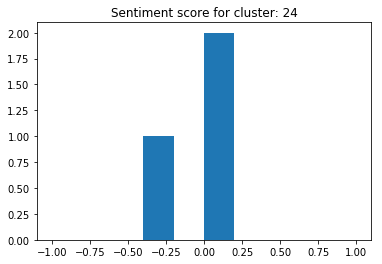

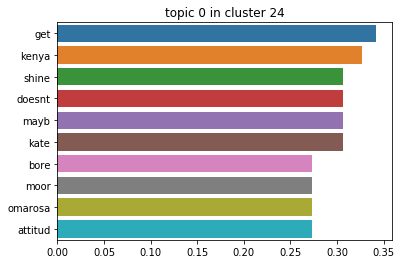

cluster  0  lunghezza  4
NUMBER OF TOPICS FOR CLUSTER  0  :  1


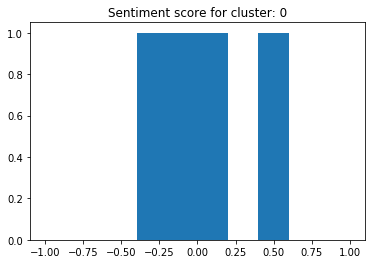

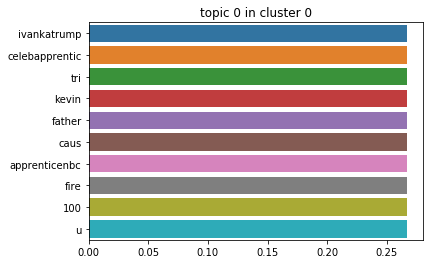

cluster  4  lunghezza  3
NUMBER OF TOPICS FOR CLUSTER  4  :  4


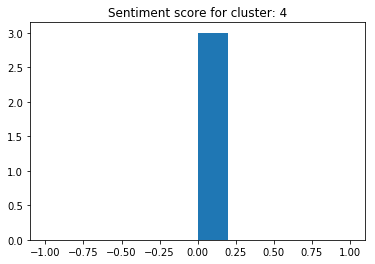

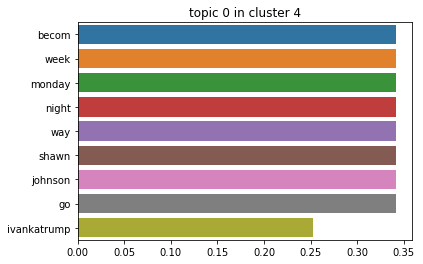

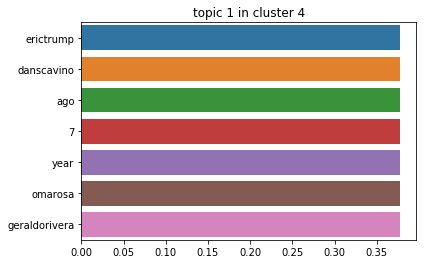

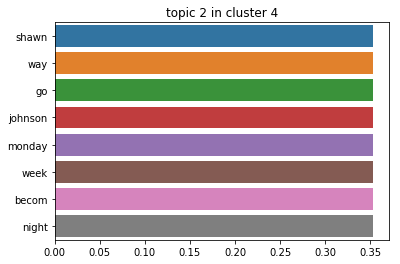

cluster  37  lunghezza  5
NUMBER OF TOPICS FOR CLUSTER  37  :  1


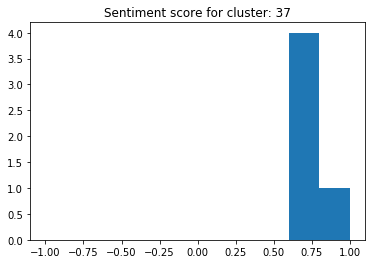

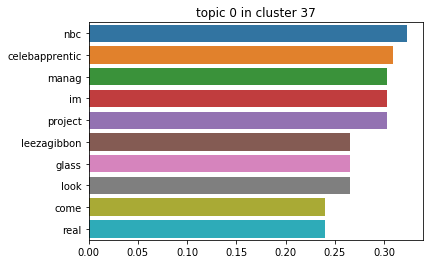

cluster  20  lunghezza  2
NUMBER OF TOPICS FOR CLUSTER  20  :  4


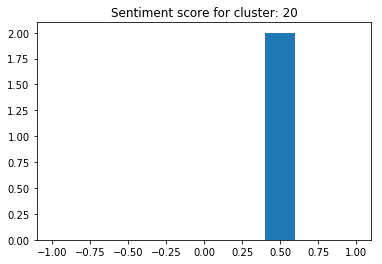

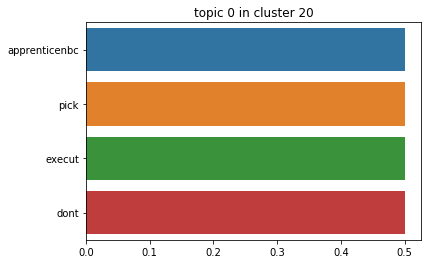

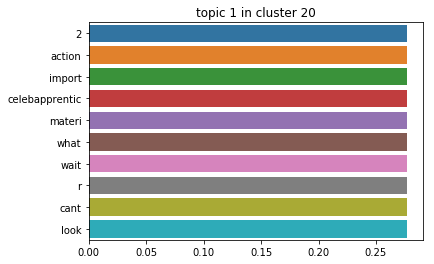

cluster  11  lunghezza  2
NUMBER OF TOPICS FOR CLUSTER  11  :  1


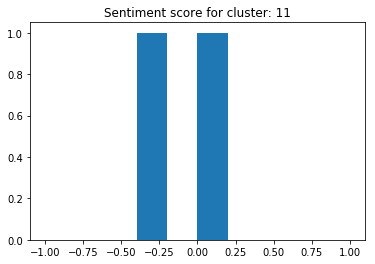

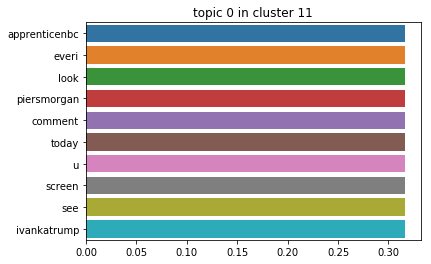

cluster  74  lunghezza  3
NUMBER OF TOPICS FOR CLUSTER  74  :  2


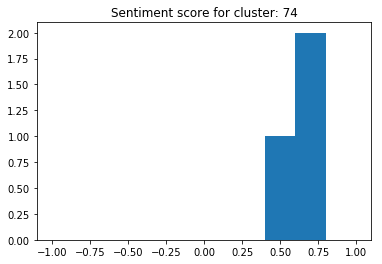

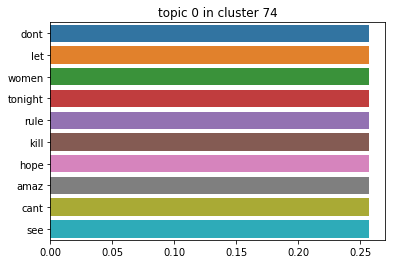

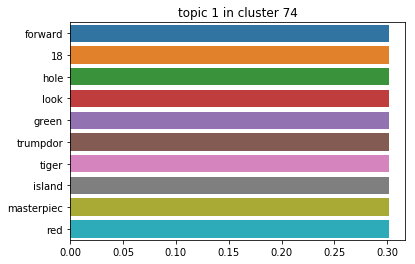

cluster  1  lunghezza  4
NUMBER OF TOPICS FOR CLUSTER  1  :  8


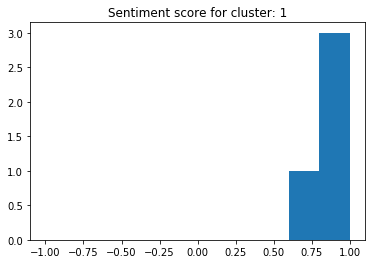

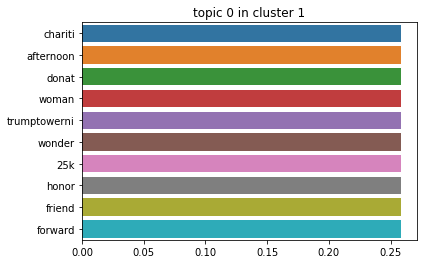

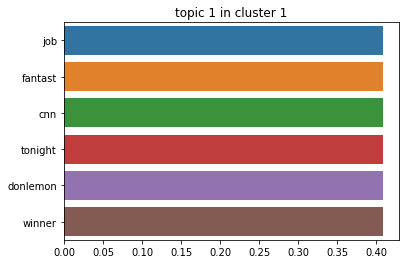

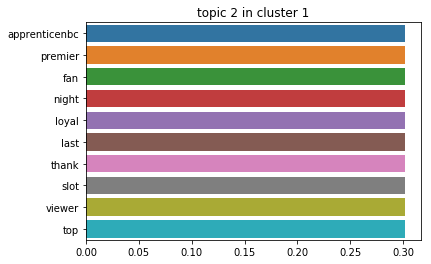

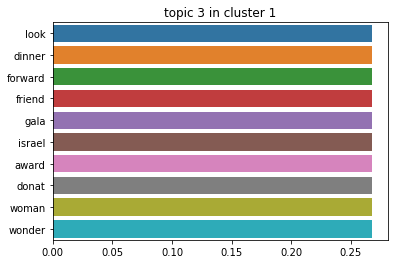

cluster  26  lunghezza  3
NUMBER OF TOPICS FOR CLUSTER  26  :  1


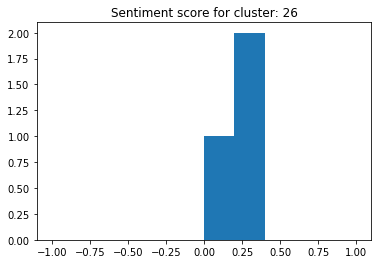

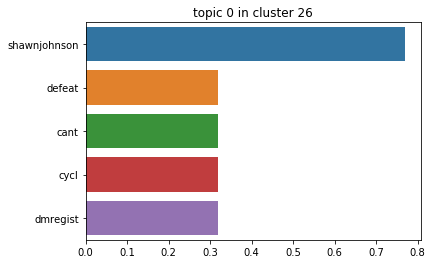

cluster  62  lunghezza  2
NUMBER OF TOPICS FOR CLUSTER  62  :  3


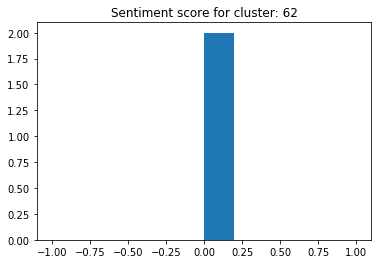

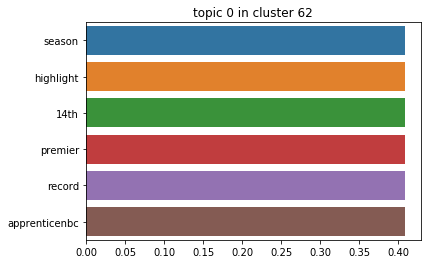

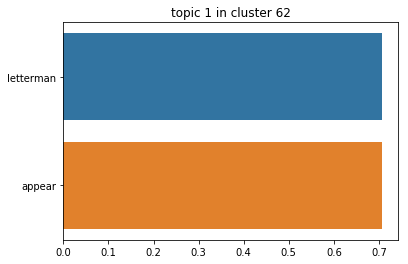

cluster  19  lunghezza  2
NUMBER OF TOPICS FOR CLUSTER  19  :  1


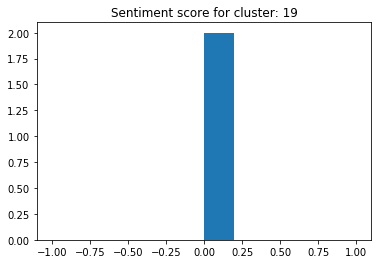

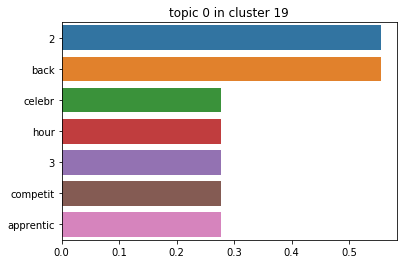

cluster  36  lunghezza  4
NUMBER OF TOPICS FOR CLUSTER  36  :  1


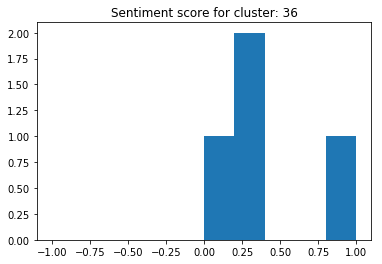

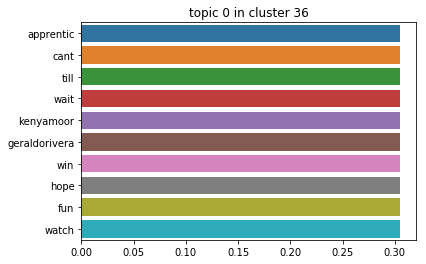

cluster  22  lunghezza  2
NUMBER OF TOPICS FOR CLUSTER  22  :  1


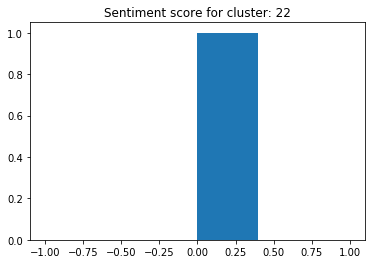

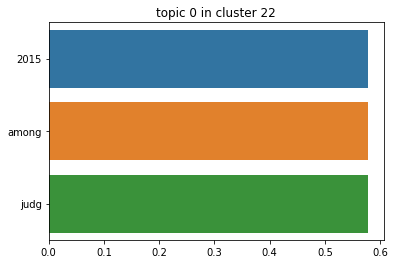

cluster  21  lunghezza  2
NUMBER OF TOPICS FOR CLUSTER  21  :  1


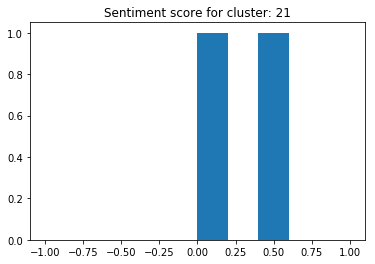

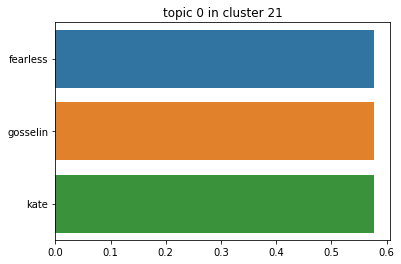

cluster  15  lunghezza  3
NUMBER OF TOPICS FOR CLUSTER  15  :  1


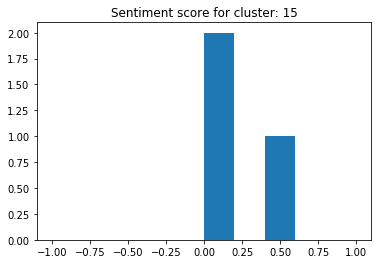

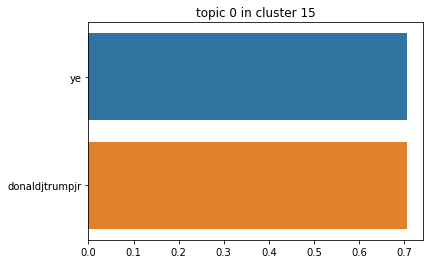

cluster  54  lunghezza  2
NUMBER OF TOPICS FOR CLUSTER  54  :  2


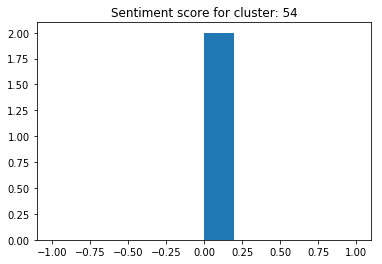

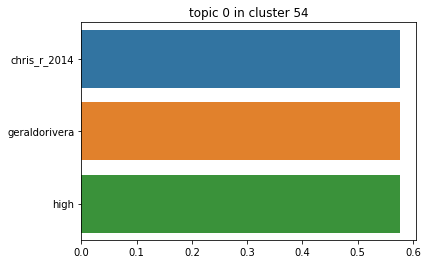

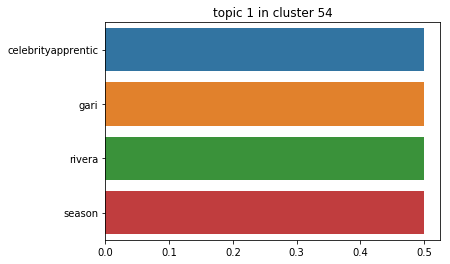

cluster  5  lunghezza  1794
NUMBER OF TOPICS FOR CLUSTER  5  :  1


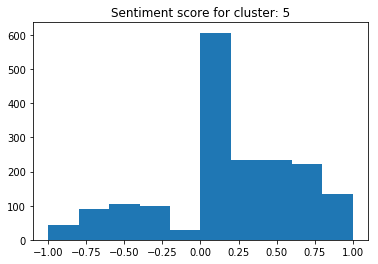

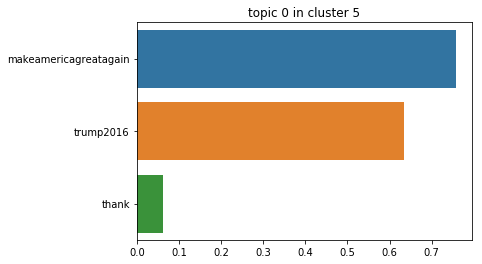

cluster  12  lunghezza  2
NUMBER OF TOPICS FOR CLUSTER  12  :  1


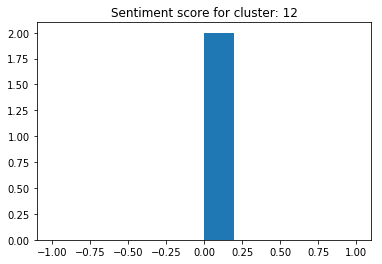

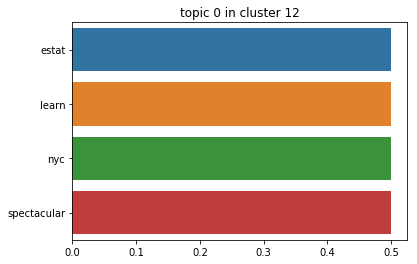

cluster  17  lunghezza  2
NUMBER OF TOPICS FOR CLUSTER  17  :  2


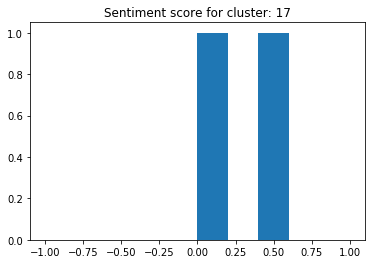

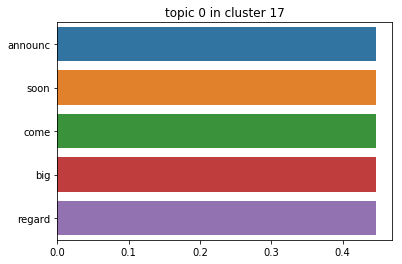

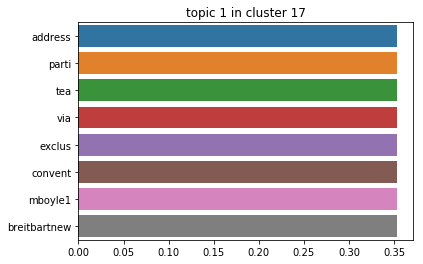

cluster  7  lunghezza  2
NUMBER OF TOPICS FOR CLUSTER  7  :  2


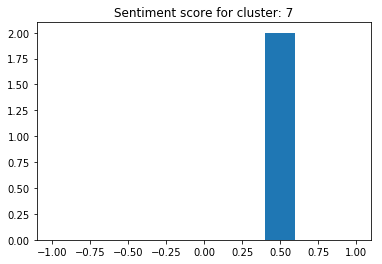

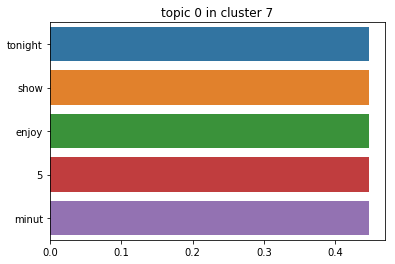

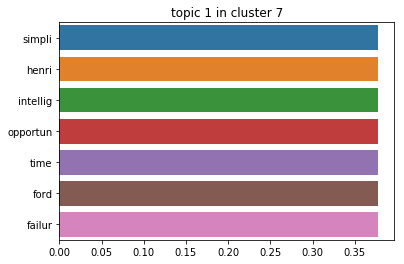

cluster  2  lunghezza  2
NUMBER OF TOPICS FOR CLUSTER  2  :  2


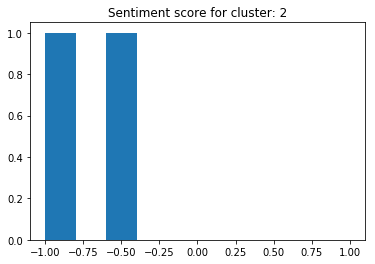

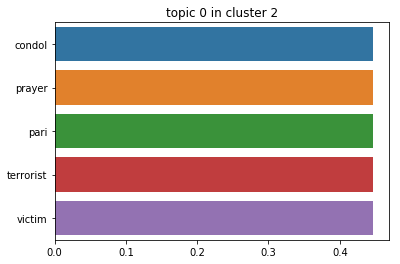

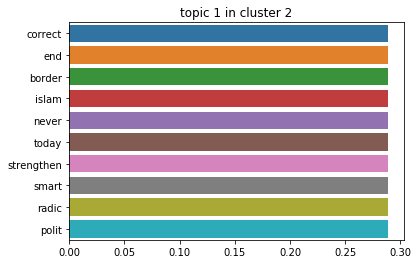

cluster  3  lunghezza  2
NUMBER OF TOPICS FOR CLUSTER  3  :  1


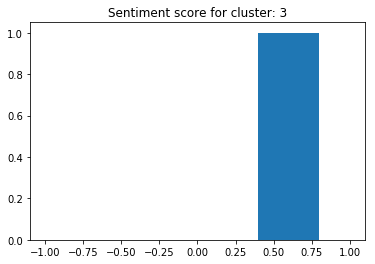

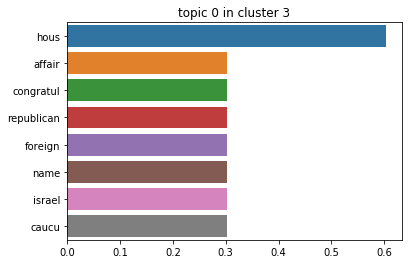

cluster  8  lunghezza  3
NUMBER OF TOPICS FOR CLUSTER  8  :  2


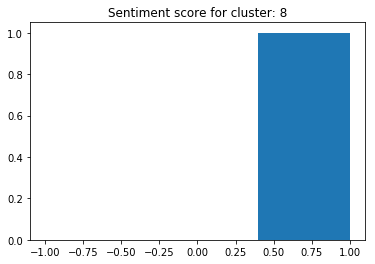

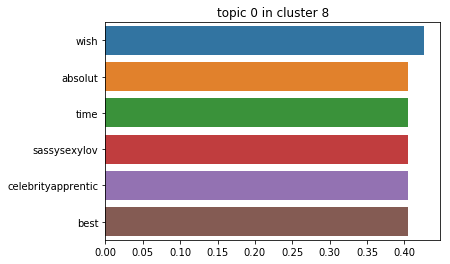

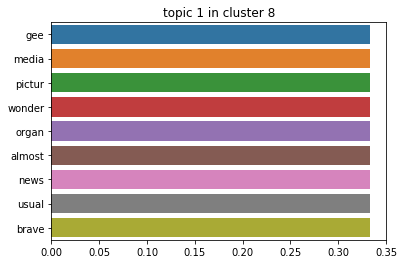

cluster  16  lunghezza  2
NUMBER OF TOPICS FOR CLUSTER  16  :  7


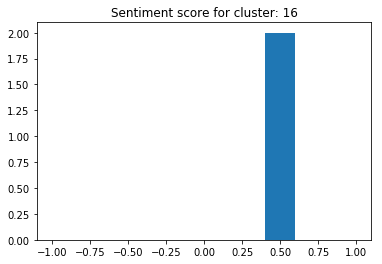

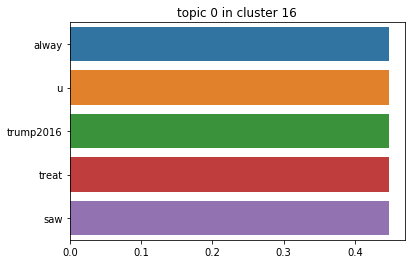

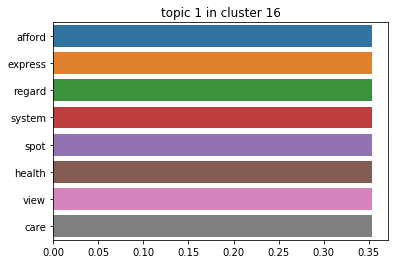

cluster  30  lunghezza  184
NUMBER OF TOPICS FOR CLUSTER  30  :  1


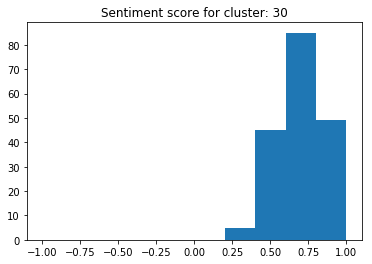

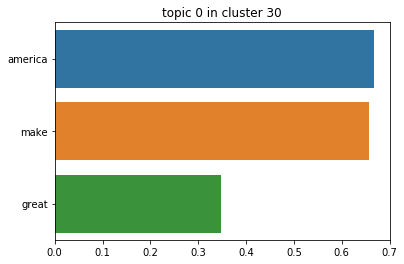

cluster  14  lunghezza  80
NUMBER OF TOPICS FOR CLUSTER  14  :  1


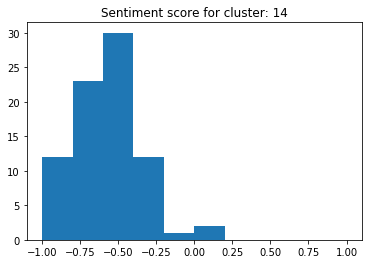

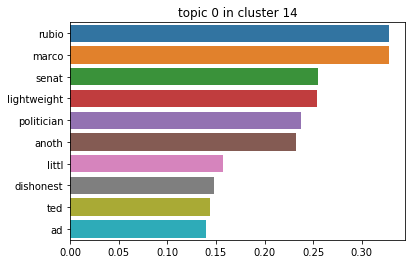

cluster  6  lunghezza  2
NUMBER OF TOPICS FOR CLUSTER  6  :  2


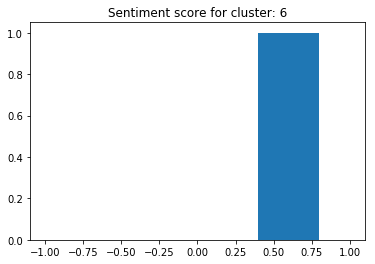

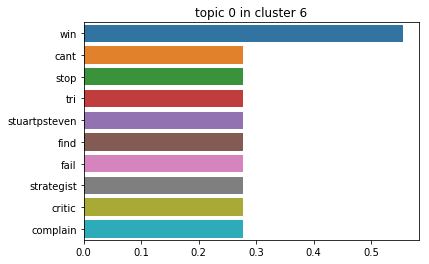

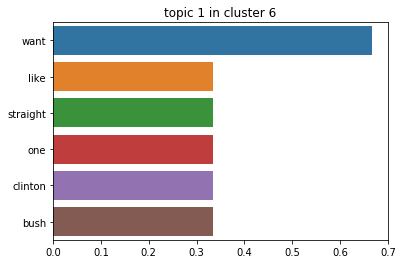

cluster  50  lunghezza  2
NUMBER OF TOPICS FOR CLUSTER  50  :  4


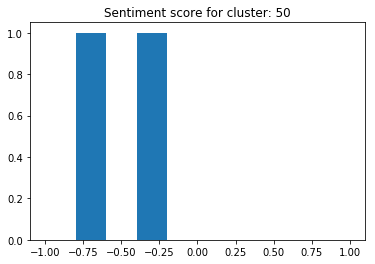

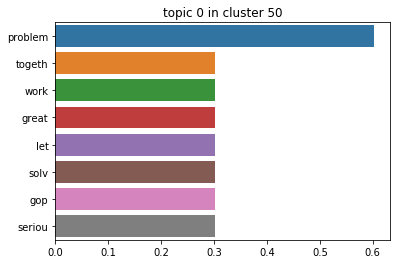

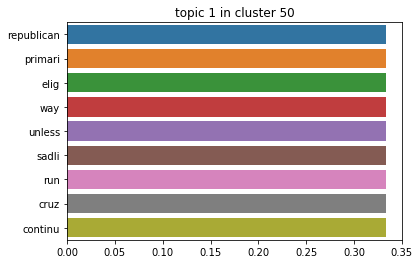

cluster  18  lunghezza  2
NUMBER OF TOPICS FOR CLUSTER  18  :  1


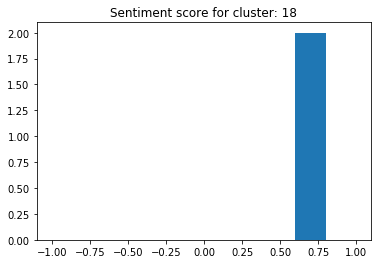

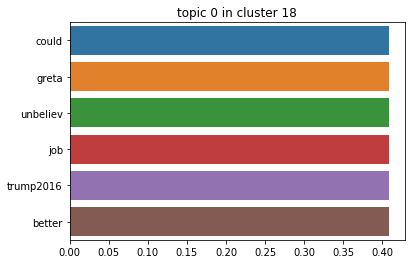

cluster  13  lunghezza  2
NUMBER OF TOPICS FOR CLUSTER  13  :  1


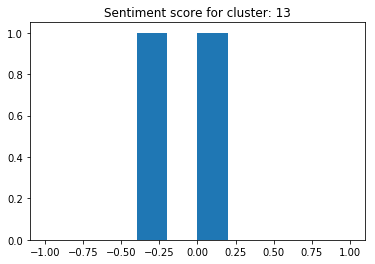

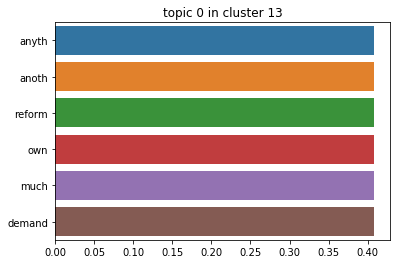

cluster  76  lunghezza  2
NUMBER OF TOPICS FOR CLUSTER  76  :  1


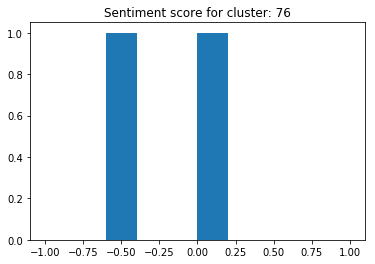

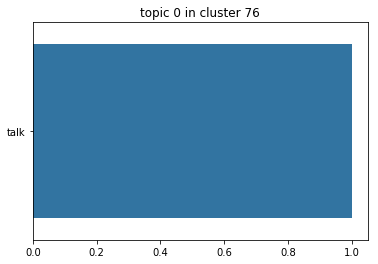

cluster  9  lunghezza  2
NUMBER OF TOPICS FOR CLUSTER  9  :  2


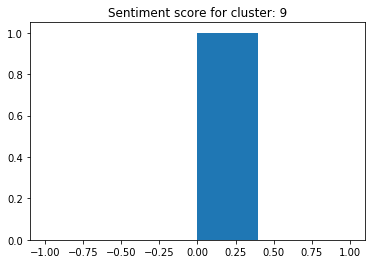

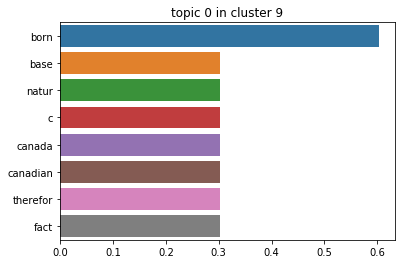

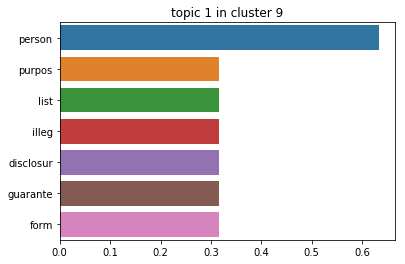

In [89]:
g = res1.drop(["vaderScore"],axis=1)

for cluster in g["labels"].unique():
    g1 = g[g["labels"] == cluster]
    d1 = dataWithText[dataWithText["labels"] == cluster]
    if len(g1) >= 2:
        meanTf = []
        for column in g1.columns:
            if column != "labels":
                m = g1[column].mean()
                meanTf.append([column,m])

        meanTfOrdered = sorted(meanTf, key=itemgetter(1),reverse = True)
        #print("cluster ",cluster," lunghezza ", len(g1), ":\n", str(meanTfOrdered[0:5]) + "\n")

        tokenizer = RegexpTokenizer(r'\w+')
        counted = pd.Series(' '.join(d1['m']).split()).value_counts()
        #counted = counted[5:] #5 per label 1 
        #counted = counted[counted > ]
        d1['m'] = d1['m'].apply(lambda x: " ".join(x for x in x.split() if x in counted))

        corpus = d1["m"].tolist()
        #print(len(corpus))
        corp = []
        for string in corpus:
            tokens = tokenizer.tokenize(string)
            corp.append(tokens)

        dictionary = corpora.Dictionary(corp)
        doc_term_matrix = [dictionary.doc2bow(doc) for doc in corp]
        tfidf = TfidfModel(doc_term_matrix)
        tfidf_corpus = tfidf[doc_term_matrix]

        start,stop,step=1,10,1
        nTopics = plot_graph(corp,start,stop,step)
        print("cluster ",cluster," lunghezza ", len(g1))
        print("NUMBER OF TOPICS FOR CLUSTER ", cluster, " : ", nTopics)
        words = 7
        lsamodel = LsiModel(tfidf_corpus, num_topics=nTopics, id2word = dictionary)  # train model
        #print(lsamodel.show_topics(num_topics = -1,num_words = words))

        plt.hist(d1["vaderScore"],bins=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
        plt.title("Sentiment score for cluster: " + str(cluster))
        plt.show()
        
        #piechart
        topics = lsamodel.show_topics(num_topics=-1, num_words=10, log=True, formatted=False)
        #print(g)
        for topic in topics:
            words = []
            weights = []
            for word in topic[1]:
                if abs(word[1]) > 0.05:
                    words.append(word[0])
                    #prendi valore assoluto perchè positivo/negativo non ha senso 
                    weights.append(abs(word[1]))
            labels = words
            sizes = weights
            plt.title("topic " + str(topic[0]) + " in cluster " + str(cluster))
            #manca il pie o la rappresentazione
            sns.barplot(x=weights, y=words)
            plt.show()

# K means

In [ ]:
%%time
sse_list = list()
max_k = 15
plt.figure(figsize=(18,6))
for k in range(2,max_k):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(res1)
    sse = kmeans.inertia_
    sse_list.append(sse)
plt.plot(range(2,max_k), sse_list)
plt.show()

In [ ]:
#6 per il label 1 (15 cluster)
#monthe vader alzano la silhouette

#per label 2 week year peggiora sse ma aumenta silhouette
#solo vader e tfidf abbassano di un botto l'sse per label 2


#sembra che usare week year peggiori l'sse ma aumenti di molto la silhouette. Come interpretare? cosa preferire?
true_k =6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=10)
model.fit(res1)
print(model.inertia_)
print
labels = model.labels_
res1["labels"] = labels
dataWithText["labels"] = labels
d = silhouette_score(res1, labels,metric='euclidean')
print(d)

In [ ]:
#per descrivere i cluster prendi i valori con tfidf più alto
g = res1.drop(["vaderScore"],axis=1)

for cluster in g["labels"].unique():
    g1 = g[g["labels"] == cluster]
    d1 = dataWithText[dataWithText["labels"] == cluster]
    meanTf = []
    for column in g1.columns:
        if column != "labels":
            m = g1[column].mean()
            meanTf.append([column,m])
    
    meanTfOrdered = sorted(meanTf, key=itemgetter(1),reverse = True)
    print("cluster ",cluster," lunghezza ", len(g1), ":\n", str(meanTfOrdered[0:5]) + "\n")
    el = random.randint(g1.index[0],g1.index[len(g1)-1])
    el1 = random.randint(g1.index[0],g1.index[len(g1)-1])
    el2 = random.randint(g1.index[0],g1.index[len(g1)-1])
    #print(res.iloc[el]["noTags_punct"] + "\n")
    #print(res.iloc[el1]["noTags_punct"]+ "\n")
    #print(res.iloc[el2]["noTags_punct"]+ "\n")
    
    tokenizer = RegexpTokenizer(r'\w+')

    counted = pd.Series(' '.join(d1['m']).split()).value_counts()
    #counted = counted[5:] #5 per label 1 
    counted = counted[counted > 5]
    d1['m'] = d1['m'].apply(lambda x: " ".join(x for x in x.split() if x in counted))

    corpus = d1["m"].tolist()
    #print(len(corpus))
    corp = []
    for string in corpus:
        tokens = tokenizer.tokenize(string)
        corp.append(tokens)

    dictionary = corpora.Dictionary(corp)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in corp]    
    
    start,stop,step=1,10,1
    nTopics = plot_graph(corp,start,stop,step)
    print("NUMBER OF TOPICS: ", nTopics)
    words = 7
    lsamodel = LsiModel(doc_term_matrix, num_topics=nTopics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics = -1,num_words = words))
    
    plt.hist(d1["vaderScore"])
    plt.show()

In [ ]:
g = res1.drop(["vaderScore"],axis=1)

for cluster in g["labels"].unique():
    g1 = g[g["labels"] == cluster]
    d1 = dataWithText[dataWithText["labels"] == cluster]
    meanTf = []
    for column in g1.columns:
        if column != "labels":
            m = g1[column].mean()
            meanTf.append([column,m])
    
    meanTfOrdered = sorted(meanTf, key=itemgetter(1),reverse = True)
    print("cluster ",cluster," lunghezza ", len(g1), ":\n", str(meanTfOrdered[0:5]) + "\n")
    el = random.randint(g1.index[0],g1.index[len(g1)-1])
    el1 = random.randint(g1.index[0],g1.index[len(g1)-1])
    el2 = random.randint(g1.index[0],g1.index[len(g1)-1])
    #print(res.iloc[el]["noTags_punct"] + "\n")
    #print(res.iloc[el1]["noTags_punct"]+ "\n")
    #print(res.iloc[el2]["noTags_punct"]+ "\n")
    
    tokenizer = RegexpTokenizer(r'\w+')

    counted = pd.Series(' '.join(d1['m']).split()).value_counts()
    #counted = counted[5:] #5 per label 1 
    counted = counted[counted > 5]
    d1['m'] = d1['m'].apply(lambda x: " ".join(x for x in x.split() if x in counted))

    corpus = d1["m"].tolist()
    #print(len(corpus))
    corp = []
    for string in corpus:
        tokens = tokenizer.tokenize(string)
        corp.append(tokens)

    dictionary = corpora.Dictionary(corp)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in corp]
    tfidf = TfidfModel(doc_term_matrix)
    tfidf_corpus = tfidf[doc_term_matrix]
    
    start,stop,step=1,10,1
    nTopics = plot_graph(corp,start,stop,step)
    print("NUMBER OF TOPICS: ", nTopics)
    words = 7
    lsamodel = LsiModel(tfidf_corpus, num_topics=nTopics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics = -1,num_words = words))
    
    plt.hist(d1["vaderScore"])
    plt.show()